# Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Unzip the dataset
- Train dataset
- Valid dataset

In [ ]:
!unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_90_train.zip
!unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_90_val.zip
#!unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_90_test.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Font_npy_90_val/Sample054/img054-00905.npy  
  inflating: Font_npy_90_val/Sample054/img054-00380.npy  
  inflating: Font_npy_90_val/Sample054/img054-00113.npy  
  inflating: Font_npy_90_val/Sample054/img054-00574.npy  
  inflating: Font_npy_90_val/Sample054/img054-00133.npy  
  inflating: Font_npy_90_val/Sample054/img054-00197.npy  
  inflating: Font_npy_90_val/Sample054/img054-00355.npy  
  inflating: Font_npy_90_val/Sample054/img054-00395.npy  
  inflating: Font_npy_90_val/Sample054/img054-00483.npy  
  inflating: Font_npy_90_val/Sample054/img054-00387.npy  
  inflating: Font_npy_90_val/Sample054/img054-00654.npy  
  inflating: Font_npy_90_val/Sample054/img054-00549.npy  
  inflating: Font_npy_90_val/Sample054/img054-00766.npy  
  inflating: Font_npy_90_val/Sample054/img054-00577.npy  
  inflating: Font_npy_90_val/Sample054/img054-00034.npy  
  inflating: Font_npy_90_val/Sample054/img054-00289.npy  
  inflating: Font_npy_90_val/Sample0

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torchvision import models, transforms

from torchsummary import summary

import matplotlib.pyplot as plt
import random
import time
import os

import numpy as np

# Utility functions
- fix_seeds()
- show_model_summary()
- init_weights()

In [ ]:
def fix_seeds(seed=1234):
    """ fix the seed for reproducibility """
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) 
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def show_model_summary(model):
    """ print model parameters """
    
    print('{:=^60}'.format("="))
    print('{:^60}'.format("model summary"))
    print('{:=^60}'.format("="))
    for param_tensor in model.state_dict():
        print('%-30s'%param_tensor, '{:^30}'.format(str(model.state_dict()[param_tensor].size())))
    print('{:=^60}'.format("="))
    print()

In [ ]:
def init_weights(m):
    """initialize the weights of model """
    
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight.data)
        if m.bias is not None:
            torch.nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight.data, mean=1, std=0.02)
        torch.nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight.data)
        torch.nn.init.normal_(m.bias.data)

# Load dataset

In [ ]:
# load dataset
import glob
class MyDataset(Dataset):
    def __init__(self, npy_dir): # image file (*.npy) 들을 포함하고 있는 디렉토리 경로 npy_dir 로 받아야, 
        self.dir_path = npy_dir
        self.to_tensor = transforms.ToTensor()

        # all npy path
        self.npy_path = glob.glob(os.path.join(npy_dir, '*','*.npy')) 

    def __getitem__(self, index):
        # load data
        single_data_path = self.npy_path[index]
        data = np.load(single_data_path, allow_pickle=True)
        
        image = data[0]
        image = self.to_tensor(image)
        label = data[1]
       
        return (image, label)

    def __len__(self):
        return len(self.npy_path)



# unzip 한 디렉토리 있는 path 그대로 넣어야, 디렉토리 옆 점 3개 누르면 '경로 복사' 있음 - 위의 사진 참조
train_data = MyDataset("/content/Font_npy_90_train") 
valid_data = MyDataset("/content/Font_npy_90_val")
#test_data = MyDataset("/content/Font_npy_90_test")

print(f'size of train data: {len(train_data)}')
print(f'size of valid data: {len(valid_data)}')
#print(len(test_data))

size of train data: 37232
size of valid data: 7800


In [ ]:
batch_size = 50
fix_seeds(seed=1234)
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

fix_seeds(seed=1234)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           shuffle=True)
"""
fix_seeds(seed=1234)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size,
                                           shuffle=False)
"""


# check dataloader
image, label = next(iter(valid_loader))
print(f'image shape: {image.shape}')
print(f'label shape: {label.shape}')

image shape: torch.Size([50, 1, 90, 90])
label shape: torch.Size([50])


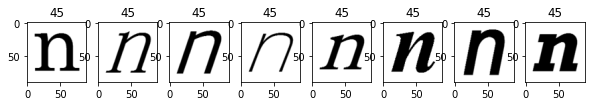

In [ ]:
# visualize data
# character - encoded_label dict , 데이터 확인해보고 싶을 때 참조
label_dict = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17,
'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'P': 24, 'Q': 25, 
'R': 26, 'S': 27, 'T': 28, 'U': 29, 'V': 30, 'W': 31, 'X': 32, 'Y': 33, 
'Z': 34, 'a': 35, 'b': 36, 'd': 37, 'e': 38, 'f': 39, 'g': 40, 'h': 41, 
'i': 42, 'j': 43, 'm': 44, 'n': 45, 'o': 46, 'q': 47, 'r': 48, 't': 49, 'u': 50, 'y': 51}

# image_show function : num 수 만큼 dataset 내의 data를 보여주는 함수
def image_show(dataset, num):
  fig = plt.figure(figsize=(10,10))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i+1200][0].squeeze(), cmap = "gray")
    plt.title(dataset[i+1200][1])

image_show(train_data, 8)

# GPU Configuration

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
!nvidia-smi

cuda
Sun Dec 12 13:51:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    35W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

# Define Model
- based on CNN

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # input shape = (1, 90, 90)
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (90, 90) -> (45, 45)

            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (45, 45) -> (22, 22)

            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (22, 22) -> (11, 11)

            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (11, 11) -> (5, 5)

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
             nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (5, 5) -> (2, 2)
        )


        self.fc = nn.Sequential(
            nn.Linear(2*2*128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            # nn.Linear(1024, 1024),
            # nn.ReLU(),
            # nn.Dropout(0.2),

            nn.Linear(512, 52),
            nn.BatchNorm1d(52),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Utility functions

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    steps = len(train_loader)
    epoch_loss, acc = 0, 0
    total_loss, cnt = 0, 0

    for i, (image, label) in enumerate(train_loader, 1):
        image = image.to(device)
        label = label.to(device)

        output = model(image)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        cnt += 1

        epoch_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        acc += (preds == label).sum().item()

        if i % (steps / 5) == 0:
            avg_loss = total_loss / cnt
            print(f'Batch steps: [{i}|{steps}]({100 * i // steps}%) Average Train Loss: {avg_loss:.4f}')
            total_loss, cnt = 0, 0

    # return avg_epoch_loss, accuracy
    avg_epoch_loss = epoch_loss / len(train_loader)
    pct = 100 * acc / len(train_loader.dataset)
    return avg_epoch_loss, pct

In [ ]:
def evaluate(model, device, data_loader, criterion):
    model.eval()
    epoch_loss, acc = 0, 0
    with torch.no_grad():
        for (image, label) in data_loader:
            image = image.to(device)
            label = label.to(device)

            output = model(image)
            loss = criterion(output, label)

            _, pred = torch.max(output.data, 1)
            acc += (pred == label).sum().item()
            epoch_loss += loss.item()

    pct = 100 * acc / len(data_loader.dataset)
    # return average loss, accuracy
    return epoch_loss / len(data_loader.dataset), pct

# Train the model

In [ ]:
fix_seeds(seed=1234)
model = ConvNet().to(DEVICE)
model.apply(init_weights)
show_model_summary(model)
summary(model,(1,90,90),batch_size=batch_size)

learning_rate = 1e-3
EPOCHS = 20

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_epoch = 0
best_valid_loss = float('inf')
epoch_duration = 0

results = {
    'train': {'loss': [], 'acc': []},
    'valid': {'loss': [], 'acc': []},
}

start = time.time()
for epoch in range(1, EPOCHS + 1):
    print(f'epoch: {epoch}')
    train_loss, train_acc = train(model, DEVICE, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, DEVICE, valid_loader, criterion)

    # save the results
    results['train']['loss'].append(train_loss)
    results['train']['acc'].append(train_acc)
    results['valid']['loss'].append(valid_loss)
    results['valid']['acc'].append(valid_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Accuracy(%): {train_acc:.2f}')
    print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy(%): {valid_acc:.2f}')

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch
        torch.save(model.state_dict(), f'20161608.pth')

    # compute training time per epoch
    end = time.time()
    duration = end - start
    print(f"Total Time elapse : {duration/60:.2f} minutes")
    print()

    # calculate epoch duration
    if epoch_duration == 0:
        epoch_duration = duration / 60

    # if next epoch is expected to exceed the 10 minute,
    # end the for-loop
    if (epoch + 1) > (10 / epoch_duration):
        break

# compute total training time
end = time.time()
duration = end - start
print(f"Training takes {duration/60:.2f} minutes")

                       model summary                        
conv.0.weight                     torch.Size([8, 1, 3, 3])   
conv.1.weight                         torch.Size([8])        
conv.1.bias                           torch.Size([8])        
conv.1.running_mean                   torch.Size([8])        
conv.1.running_var                    torch.Size([8])        
conv.1.num_batches_tracked             torch.Size([])        
conv.4.weight                    torch.Size([16, 8, 3, 3])   
conv.5.weight                         torch.Size([16])       
conv.5.bias                           torch.Size([16])       
conv.5.running_mean                   torch.Size([16])       
conv.5.running_var                    torch.Size([16])       
conv.5.num_batches_tracked             torch.Size([])        
conv.8.weight                    torch.Size([32, 16, 3, 3])  
conv.9.weight                         torch.Size([32])       
conv.9.bias                           torch.Size([32])       
conv.9.ru

# Plot loss & accuracy

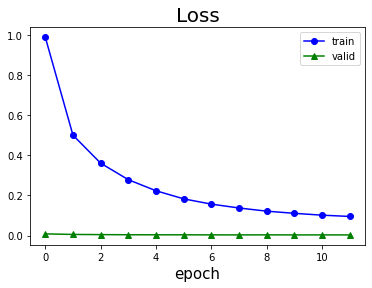

In [ ]:
plt.plot(results['train']['loss'], color='b', marker='o', label='train')
plt.plot(results['valid']['loss'], color='g', marker='^', label='valid')
plt.title('Loss', fontsize=20)
plt.xlabel('epoch', fontsize=15)
plt.legend()
plt.show()

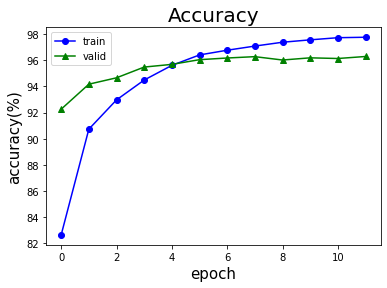

In [ ]:
plt.plot(results['train']['acc'], color='b', marker='o', label='train')
plt.plot(results['valid']['acc'], color='g', marker='^', label='valid')
plt.title('Accuracy', fontsize=20)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('accuracy(%)', fontsize=15)
plt.legend()
plt.show()

# Analyze the results


In [ ]:
label_class = {}
for k, v in label_dict.items():
    label_class[v] = k
print(label_class)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'P', 25: 'Q', 26: 'R', 27: 'S', 28: 'T', 29: 'U', 30: 'V', 31: 'W', 32: 'X', 33: 'Y', 34: 'Z', 35: 'a', 36: 'b', 37: 'd', 38: 'e', 39: 'f', 40: 'g', 41: 'h', 42: 'i', 43: 'j', 44: 'm', 45: 'n', 46: 'o', 47: 'q', 48: 'r', 49: 't', 50: 'u', 51: 'y'}


In [ ]:
def analyze(model, device, data_loader, criterion):
    model.eval()
    corrects = {}
    total = {}
    acc = 0
    with torch.no_grad():
        for (image, label) in data_loader:
            image = image.to(device)
            label = label.to(device)

            output = model(image)
            loss = criterion(output, label)

            _, pred = torch.max(output.data, 1)
            
            for label_, pred_ in zip(label, pred):
                if label_ == pred_:
                    corrects[label_.item()] = corrects.get(label_.item(), 0) + 1
                total[label_.item()] = total.get(label_.item(), 0) + 1
            
    corrects = dict(sorted(corrects.items()))
    total = dict(sorted(total.items()))
    return corrects, total

In [ ]:
def test_evaluate(model, device, test_loader):
    model_test.eval()
    with torch.no_grad():
        correct = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_test(images)
            _,predicted = torch.max(outputs.data,1)
            correct += (predicted==labels).sum()
    print('Accuracy of the last_model network on the {} test images: {} %'.\
        format(len(test_loader.dataset), 100 * correct / len(test_loader.dataset)))

In [ ]:
model_test = ConvNet().to(DEVICE)
model_test.load_state_dict(torch.load("20161608.pth"))

test_evaluate(model, DEVICE, valid_loader)

Accuracy of the last_model network on the 7800 test images: 96.28205108642578 %


In [ ]:
label_acc = {}
corrects, total = analyze(model, DEVICE, valid_loader, criterion)
print('Accuracy for all class')
for class_name, correct_count in corrects.items():
    pct = 100 * correct_count / total[class_name]
    print(f"class {label_class[class_name]:2s}: {pct:.2f} %")
    label_acc[label_class[class_name]] = pct
print(label_acc)

Accuracy for all class
class 0 : 73.33 %
class 1 : 94.67 %
class 2 : 100.00 %
class 3 : 100.00 %
class 4 : 100.00 %
class 5 : 100.00 %
class 6 : 100.00 %
class 7 : 99.33 %
class 8 : 98.00 %
class 9 : 98.67 %
class A : 96.67 %
class B : 96.67 %
class C : 99.33 %
class D : 98.00 %
class E : 97.33 %
class F : 96.67 %
class G : 95.33 %
class H : 96.00 %
class I : 95.33 %
class J : 98.67 %
class K : 100.00 %
class L : 98.00 %
class M : 98.00 %
class N : 97.33 %
class P : 97.33 %
class Q : 98.00 %
class R : 96.67 %
class S : 98.00 %
class T : 98.67 %
class U : 92.00 %
class V : 100.00 %
class W : 97.33 %
class X : 100.00 %
class Y : 93.33 %
class Z : 100.00 %
class a : 94.67 %
class b : 96.00 %
class d : 96.67 %
class e : 92.67 %
class f : 94.67 %
class g : 94.00 %
class h : 94.67 %
class i : 95.33 %
class j : 96.00 %
class m : 94.67 %
class n : 92.67 %
class o : 94.00 %
class q : 92.00 %
class r : 98.67 %
class t : 95.33 %
class u : 94.00 %
class y : 92.00 %
{'0': 73.33333333333333, '1': 94

Text(0.5, 1.0, 'Accuracy of valid set')

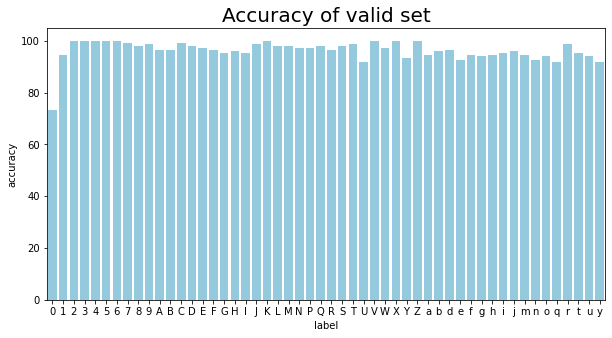

In [ ]:
import seaborn as sns
import pandas as pd

df =  pd.DataFrame({
    'label': label_acc.keys(),
    'accuracy': label_acc.values()
})
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df, x='label', y='accuracy', color='skyblue')
ax.set_title('Accuracy of valid set', fontsize=20)